# Uncertain Social Dilemma

> Class for two states social dilemma with partial observing agents

In [ ]:
#| default_exp Environments/UncertainSocialDilemma

In [ ]:
#| hide
# Imports for the nbdev development environment
from nbdev.showdoc import *

# Example

In [ ]:
from pyCRLD.Environments.UncertainSocialDilemma import UncertainSocialDilemma
from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Agents.POStrategyActorCritic import POstratAC
from pyCRLD.Agents.StrategyActorCritic import stratAC

from pyCRLD.Utils import FlowPlot as fp
import numpy as np

### Full observation

An example for a two states Prisonners Dilemma, first without observation noise.

Array([[4.45, 2.37],
       [1.3 , 1.02]], dtype=float32)

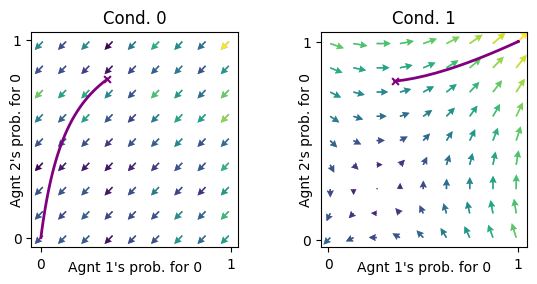

In [ ]:
env_fullObs = UncertainSocialDilemma(R1=5, T1=6, S1=-1, P1=0, R2=5, T2=2, S2=-1, P2=0, pC=0.5, obsnoise=0)
mae_fullObs = POstratAC(env=env_fullObs, learning_rates=0.1, discount_factors=0.9)
pc00, pc01, pc10, pc11 = 0.35, 0.35, 0.8, 0.8
X = [[[pc00, 1-pc00],     #initial policy to visulize learning trajectory
      [pc01, 1-pc01]], 
     [[pc10, 1-pc10], 
      [pc11, 1-pc11]]] 
X = np.array(X)
xtraj, fixedpointreached = mae_fullObs.trajectory(X)

x = ([0], [0,1], [0])  # Plotting on the x-axis the [0]'s agents probability in both observations [0,1] to cooprate [0]
y = ([1], [0,1], [0])  # Plotting on the y-axis the [1]'s agents probability in both observations [0,1] to cooprate [0]
ax = fp.plot_strategy_flow(mae_fullObs, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax);

In state 0 both agents learn to defect. In state 1 they learn to cooperate if their initial cooperation prpability is not to low.

If we use the stratAC class instead of the POstratAC class, nothing changes because there is no observation noise.

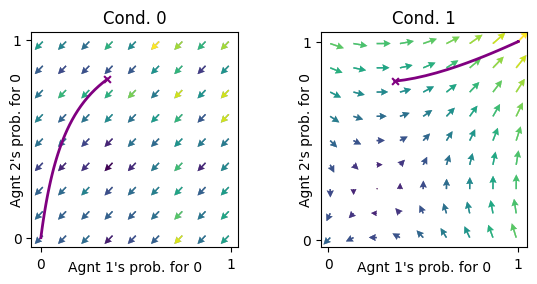

In [ ]:
mae_fullObs_strat = stratAC(env=env_fullObs, learning_rates=0.1, discount_factors=0.9)
xtraj, fixedpointreached = mae_fullObs_strat.trajectory(X)

ax = fp.plot_strategy_flow(mae_fullObs_strat, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax);

### Random observation

What happens when in each state the agents think they are in the true or in the other state with the same propability?

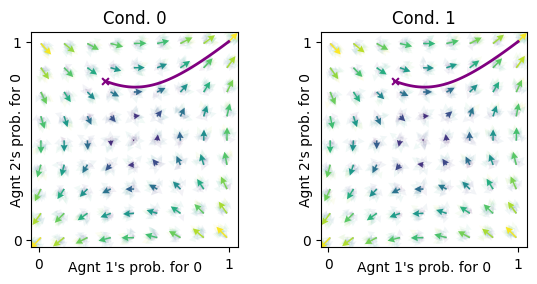

In [ ]:
env_randObs = UncertainSocialDilemma(R1=5, T1=6, S1=-1, P1=0, R2=5, T2=2, S2=-1, P2=0, pC=0.5, obsnoise=0.5)
mae_randObs = POstratAC(env=env_randObs, learning_rates=0.1, discount_factors=0.9)
xtraj, fixedpointreached = mae_randObs.trajectory(X)

ax = fp.plot_strategy_flow(mae_randObs, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax);

The learning trajectories in both states are the same. In both states the agents can learn to defect or to cooperate, depending on the inital policy.

### Uncertain observation

How does a high observation noise of 0.45 (hence the it is still more probable to observe the true state) influence the learning dynamics compared to a low observation noise of 0.2?

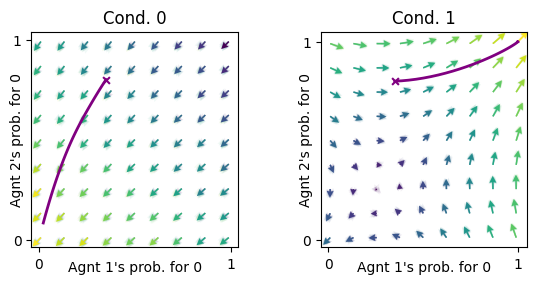

In [ ]:
env_bituncertObs = UncertainSocialDilemma(R1=5, T1=6, S1=-1, P1=0, R2=5, T2=2, S2=-1, P2=0, pC=0.5, obsnoise=0.2)
mae_bituncertObs = POstratAC(env=env_bituncertObs, learning_rates=0.1, discount_factors=0.9)
xtraj, fixedpointreached = mae_bituncertObs.trajectory(X)

ax = fp.plot_strategy_flow(mae_bituncertObs, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax);

For a low noise the dynamics are close the the dynamics for full observation.

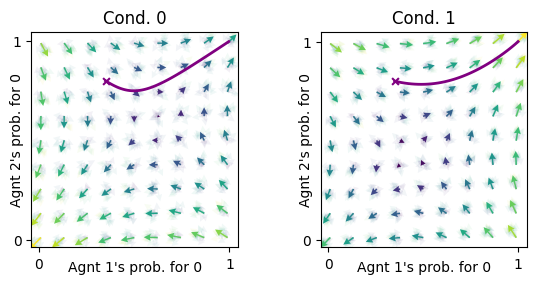

In [ ]:
env_veryuncertObs = UncertainSocialDilemma(R1=5, T1=6, S1=-1, P1=0, R2=5, T2=2, S2=-1, P2=0, pC=0.5, obsnoise=0.45)
mae_veryuncertObs = POstratAC(env=env_veryuncertObs, learning_rates=0.1, discount_factors=0.9)
xtraj, fixedpointreached = mae_veryuncertObs.trajectory(X)

ax = fp.plot_strategy_flow(mae_veryuncertObs, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax);

Only for relatively high noise we clearly see its influence. 

## Implementation

In [ ]:
#| export
from pyCRLD.Environments.Base import ebase
from pyCRLD.Utils.Helpers import make_variable_vector

from fastcore.utils import *
from fastcore.test import *

from typing import Iterable
import numpy as np

In [ ]:
#| export
class UncertainSocialDilemma(ebase):

    def __init__(self, R1, T1, S1, P1, R2, T2, S2, P2, pC, obsnoise):
        self.N = 2
        self.M = 2
        self.Z = 2

        self.R1 = R1
        self.T1 = T1
        self.S1 = S1    
        self.P1 = P1    

        self.R2 = R2
        self.T2 = T2
        self.S2 = S2    
        self.P2 = P2    
        
        self.pC = pC  # prop. contract
        if not hasattr(obsnoise, "__iter__"):
            self.noise = np.array([obsnoise, obsnoise])
        else:
            assert len(obsnoise) == 2
            self.obsnoise = np.array(obsnoise)
        assert min(self.noise) >= 0.0

        # --
        self.T = self.TransitionTensor()
        self.R = self.RewardTensor()
        self.O = self.ObservationTensor()
        self.state = 1 # inital state
        super().__init__()

In [ ]:
#| export
@patch
def actions(self:UncertainSocialDilemma):
        return [0, 1], ["coop.", "defect."]

In [ ]:
#| export
@patch
def states(self:UncertainSocialDilemma):
        return [0, 1], ["no contract", "contract"]


In [ ]:
#| export
@patch
def TransitionTensor(self:UncertainSocialDilemma):
        """Get the Transition Tensor."""
        Tsas = np.ones((2, 2, 2, 2)) * (-1)

        Tsas[:, :, :, 0] = 1-self.pC
        Tsas[:, :, :, 1] = self.pC

        return Tsas

In [ ]:
#| export
@patch
def RewardTensor(self:UncertainSocialDilemma):
        """Get the Reward Tensor R[i,s,a1,...,aN,s']."""

        R = np.zeros((2, 2, 2, 2, 2))

        R[0, 0, :, :, 0] = [[self.R1, self.S1],
                            [self.T1, self.P1]]
        R[1, 0, :, :, 0] = [[self.R1, self.T1],
                            [self.S1, self.P1]]
        R[:, 0, :, :, 1] = R[:, 0, :, :, 0]

        R[0, 1, :, :, 1] = [[self.R2, self.S2],
                            [self.T2, self.P2]]
        R[1, 1, :, :, 1] = [[self.R2, self.T2],
                            [self.S2, self.P2]]
        R[:, 1, :, :, 0] = R[:, 1, :, :, 1]

        return R

In [ ]:
#| export
@patch
def ObservationTensor(self:UncertainSocialDilemma):

        if np.all(self.noise > 0.5):
            self.Q = 1
            Oiso = np.ones((self.N, self.Z, self.Q))
            
        else:
            self.Q = self.Z
            Oiso = np.zeros((self.N, self.Z, self.Q))

            for i in range(self.N):
                Oiso[i,0,0] = 1 - min(self.noise[i], 0.5)
                Oiso[i,0,1] = 0 + min(self.noise[i], 0.5)
                Oiso[i,1,0] = 0 + min(self.noise[i], 0.5)
                Oiso[i,1,1] = 1 - min(self.noise[i], 0.5)
            
        return Oiso

In [ ]:
#| export
@patch
def id(self:UncertainSocialDilemma):
    """
    Returns id string of environment
    """
    # Default
    R1 = self.R1
    T1 = self.T1
    S1 = self.S1
    P1 = self.P1 
    R2 = self.R1 
    T2 = self.T2
    S2 = self.S2
    P2 = self.P2 
    pC = self.pC 
    noise = self.noise if len(np.unique(self.noise))>1 else self.noise[0]

    id = f"{self.__class__.__name__}_"+\
        f"{self.N}_{str(R1)}_{str(T1)}_{str(S1)}_{str(P1)}_{str(R2)}_{str(T2)}_{str(S2)}_{str(P2)}_{str(pC)}_{str(noise)}"
    return id

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()